In [64]:
import numpy as np
from scipy import sparse
import networkx as nx
import time
import matplotlib.pyplot as plt
%matplotlib inline

#### The Lanczos algorithm for searching for eigenvalues

In [109]:
# Amat - considered matrix
# vvec - first approximation
# tilv - beta from the lanczos algorithm
def lanczos_step(Amat, Vmat, Tmat, tilv):
    eta = np.linalg.norm(tilv)
    vvec = tilv/eta
    alpha = np.linalg.norm(vvec.T.dot(Amat.dot(vvec)))
    tilv = Amat.dot(vvec) - alpha*vvec - np.expand_dims(eta*Vmat[:,-1], axis = 1)
    
    # orthogonalization
    for i in range(Vmat.shape[1]):
        tilv -= (tilv.flatten().dot(Vmat[:,i].flatten())) * np.expand_dims(Vmat[:,i], axis = 1)
    
    Vmat = np.concatenate((Vmat, vvec), axis = 1)
    
    new_diag__1, new_diag_0, new_diag_1 = [],[],[]
    if (Tmat.shape[0] != 1):
        new_diag__1 = np.append(np.append(Tmat.diagonal(-1), eta), 0)
        new_diag_0 = np.append(Tmat.diagonal(0), alpha)
        new_diag_1 = np.insert(np.append(Tmat.diagonal(1), eta), 0, 0)
    else:
        new_diag__1 = np.array([eta,0])
        new_diag_0 = np.append(Tmat.diagonal(0), alpha)
        new_diag_1 = np.array([0,eta])
    
    offsets = np.array([-1, 0, 1])
    data = np.array([
        new_diag__1,
        new_diag_0,
        new_diag_1
    ])

    t_size = Tmat.shape[0] + 1
    Tmat = sparse.dia_matrix((data, offsets), shape = (t_size, t_size))
    
    return Tmat, Vmat, tilv

In [110]:
def lanczos_algorithm(Amat, nsteps = 2):
    vvec = np.random.rand(Amat.shape[0]) # first approximation is random
    vvec /= np.linalg.norm(vvec)
    Vmat = np.expand_dims(vvec, axis = 1)
    
    alpha = np.linalg.norm(Vmat[:,-1].T.dot(Amat.dot(Vmat[:,-1])))
    Tmat = sparse.dia_matrix([alpha])
    tilv = np.expand_dims(Amat.dot(Vmat[:,-1]) - alpha*Vmat[:,-1], axis = 1)
    
    for i in range(nsteps):
        Tmat, Vmat, tilv = lanczos_step(Amat, Vmat, Tmat, tilv) 
    return Tmat, Vmat

#### First (very small) test Laplacian matrix

In [111]:
size = 10
L = np.array([  [2., -1, -1, 0, 0, 0, 0, 0, 0, 0],
                [-1, 2, -1, 0, 0, 0, 0, 0, 0, 0],
                [-1, -1, 3, -1, 0, 0, 0, 0, 0, 0],
                [0, 0, -1, 4, -1, 0, -1, 0, 0, -1],
                [0, 0, 0, -1, 4, -1, -1, -1, 0, 0],
                [0, 0, 0, 0, -1, 3, -1, -1, 0, 0],
                [0, 0, 0, -1, -1, -1, 6, -1, -1, -1],
                [0, 0, 0, 0, -1, -1, -1, 4, 0, -1],
                [0, 0, 0, 0, 0, 0, -1, 0, 2, -1],
                [0, 0, 0, -1, 0, 0, -1, -1, -1, 4]  ])

L = sparse.csr_matrix(L)

In [112]:
Tmat, Vmat = lanczos_algorithm(L, size-1)
evals_of_T, evecs_of_T = np.linalg.eig(Tmat.todense())
evecs_of_T = np.array(evecs_of_T)

In [113]:
evals_of_T, evecs_of_T = zip(*sorted(zip(evals_of_T, evecs_of_T)))
evals_of_T = np.array(evals_of_T)
evecs_of_T = np.array(evecs_of_T)
print("Eigenvalues of T:\n", evals_of_T)

Eigenvalues of T:
 [  9.99200722e-16   3.06851215e-01   1.72406597e+00   2.81086785e+00
   3.00000000e+00   3.78467863e+00   4.33735483e+00   4.84264371e+00
   6.14394237e+00   7.04959542e+00]


In [114]:
evals_of_L, evecs_of_L = np.linalg.eig(L.todense())
evals_of_L.sort()
print("Eigenvalues of L:\n", evals_of_L)

Eigenvalues of L:
 [ -1.11022302e-16   3.06851215e-01   1.72406597e+00   2.81086785e+00
   3.00000000e+00   3.78467863e+00   4.33735483e+00   4.84264371e+00
   6.14394237e+00   7.04959542e+00]


In [115]:
print("Differences between the eigenvalues of T and L\n", evals_of_T - evals_of_L)

Differences between the eigenvalues of T and L
 [  1.11022302e-15   4.44089210e-16  -3.99680289e-15   4.44089210e-15
   2.22044605e-15   2.66453526e-15  -8.88178420e-16  -1.77635684e-15
  -1.15463195e-14   2.66453526e-15]


Eigenvalues were calculated correctly

#### After the small experiment of eigenvalues correctness, let's compare time with the Incremental-IO method

##### NEXT block is a copy of the Incremental-IO code and Lanczos algorithms with time collection modifications

In [126]:
def lanczos_measure_time(Amat, cnt_required_evals):
    vvec = np.random.rand(Amat.shape[0]) # first approximation is random
    vvec /= np.linalg.norm(vvec)
    Vmat = np.expand_dims(vvec, axis = 1)
    
    alpha = np.linalg.norm(Vmat[:,-1].T.dot(Amat.dot(Vmat[:,-1])))
    Tmat = sparse.dia_matrix([alpha])
    tilv = np.expand_dims(Amat.dot(Vmat[:,-1]) - alpha*Vmat[:,-1], axis = 1)
    
    times = []
    # *2 (below), because lanczos method compute eigenvalues at both edges of spectrum
    for i in range(cnt_required_evals*3):
        start = time.time()
        Tmat, Vmat, tilv = lanczos_step(Amat, Vmat, Tmat, tilv)
        if i%3 == 1:
            end = time.time()
            times.append(end - start)
            if i%20 == 1:
                print(i//2, "done (lanczos)")
    
    return times

def V_Sigma_V_x(V_T, Sigma_diag, x, s, use_normalized_L): # V^T * Sigma * V * vec_x
    if use_normalized_L:
        Sigma_diag = 2.0 - Sigma_diag
    else:
        Sigma_diag = s - Sigma_diag
    return V_T.dot( np.multiply(Sigma_diag, (V_T.T).dot(x) ) )
def c_Ssq_E_Ssq_x(s, n, x, use_normalized_L, S_sqrt = None): # c(s,n) * S_squared * eye * S_squared * vec_x
    if use_normalized_L:
        return 2.0/s * S_sqrt * np.repeat((S_sqrt * x).sum(), len(x))
    return np.repeat(s/n * x.sum(), len(x))
def c_x(s, x, use_normalized_L):
    if use_normalized_L:
        return 2.0 * x
    else:
        return s * x

def Incremental_IO_step(W, L, s, use_normalized_L, S_sqrt, cnt_V, evals, evecs):
    L_perturbed = sparse.linalg.LinearOperator(W.shape, matvec=lambda x, W=W, V=evecs, evals=evals, s=s, n=cnt_V,
                                               is_norm=use_normalized_L, S_sqrt=S_sqrt
                                               : L.dot(x) + V_Sigma_V_x(V, evals, x, s, is_norm) 
                                               + c_Ssq_E_Ssq_x(s, n, x, is_norm, S_sqrt) 
                                               - c_x(s, x ,is_norm))
    lead_eval, lead_evec = sparse.linalg.eigsh(L_perturbed, k=1, which='LM')
    if use_normalized_L:
        evals = np.concatenate((evals, lead_eval + 2.0))
    else:
        evals = np.concatenate((evals, lead_eval + s))
    evecs = np.concatenate((evecs, lead_evec), axis=1)
    return evals, evecs

def incremental_IO_measure_time(W, L, K, use_normalized_L = False):
        
    cnt_V = W.shape[0]
    evals = np.array([0.0])
    evecs = np.array([np.zeros(cnt_V, dtype = np.float64)]).T
    current_cluster_cnt, s, S_sqrt = 1, W.sum(), None
    
    times = []
    while current_cluster_cnt <= K:
        start = time.time()
        evals, evecs = Incremental_IO_step(W, L, s, use_normalized_L, S_sqrt, cnt_V, evals, evecs)
        end = time.time()
        times.append(end - start)
        current_cluster_cnt += 1
        if current_cluster_cnt % 10 == 0:
            print(current_cluster_cnt, "done (IO)")
    
    return times

In [161]:
def incrementalIO_vs_Lanczos(Adj, cnt_required_evals):
    ## incremental-io - preparation step
    W = Adj.astype(np.float64, copy = True)
    inv_S_sqrt = np.ravel(1.0/np.sqrt(W.sum(0)))
    W = W.multiply(inv_S_sqrt).multiply(inv_S_sqrt.reshape(len(inv_S_sqrt), 1))
    L = sparse.diags(np.ravel(W.sum(0))).tocsr() - W
    ## incremental-io - measurment step
    times_IO = incremental_IO_measure_time(W, L, cnt_required_evals)
    
    ## lanczos - preparation stap
    L = sparse.diags(np.ravel(Adj.sum(0))).tocsr() - Adj
    ## lanczos - measurment step
    times_lanczos = lanczos_measure_time(L, cnt_required_evals)
    return times_IO, times_lanczos
    

In [162]:
kn = nx.read_gml('power.gml')
cnt_V = kn.number_of_nodes()
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))

adj_matrix = nx.adjacency_matrix(kn) # in CSR format
adj_matrix = adj_matrix.astype(np.float64, copy = True)

Number of vertices = 4941
Number of edges = 6594


In [ ]:
times_incremental_io, times_lanczos = incrementalIO_vs_Lanczos(adj_matrix, 40)

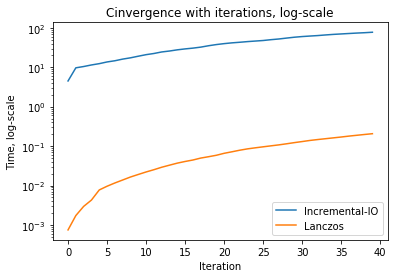

In [165]:
plt.title("Cinvergence with iterations, log-scale")
plot = plt.semilogy(np.cumsum(times_incremental_io), label = 'Incremental-IO')
plot = plt.semilogy(np.cumsum(times_lanczos), label = 'Lanczos')
plt.xlabel("Iteration")
plt.ylabel("Time, log-scale")
plt.legend()
plt.show()

#### Iterations of the Lanczos method take LESS time